# Data Preparation

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

path = "mypath"

In [ ]:
df_5 = xr.open_dataset(path + 'pv.netcdf')
ss_ids = list(df_5.keys())

## Missing data

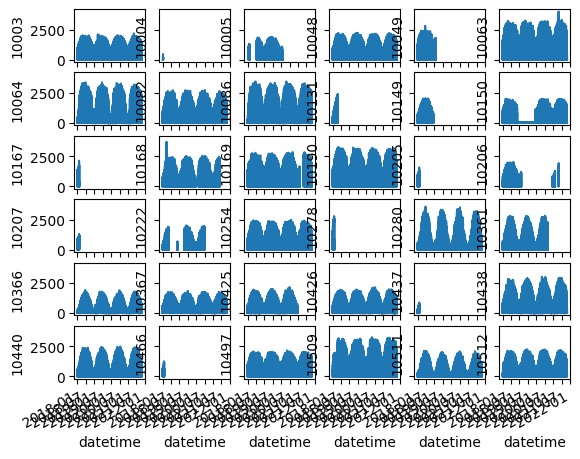

In [ ]:
_, ax = plt.subplots(6,6, sharex=True, sharey=True)

for i, ss in enumerate(ss_ids[:36]):
  df_5[ss].plot(ax=ax[i//6][i%6])

Data is mostly present or missing in chunks

In [ ]:
heatmap_missing_data_nan = np.full((37*37), np.nan)

for i, ss in enumerate(ss_ids):
  if i % 10 == 0: print(i)
  heatmap_missing_data_nan[i] = sum(~np.isnan(df_5[ss].data))/len(df_5[ss].data)

np.savetxt(path+'heatmap_missing_data_nan.csv', heatmap_missing_data_nan, delimiter=',')
heatmap_missing_data_nan = np.genfromtxt(path+'heatmap_missing_data_nan.csv', delimiter=',')

print("On average %f of the data is available, the number of stations where less than half of the data is available is %d"
      %(np.nanmean(heatmap_missing_data_nan), np.sum(np.where(heatmap_missing_data_nan < 0.5, 1, 0))))

On average 0.705039 of the data is available, the number of stations where less than half of the data is available is 355


In [ ]:
# create availability column
data_available = pd.Series(heatmap_missing_data_nan[:len(ss_ids)], index=np.array(ss_ids).astype(int))
data_available = data_available.sort_index()
data_available = data_available.drop(index=27068)

# add to metadata
df_stations_metadata = pd.read_csv(path+'metadata.csv')
df_stations_metadata_available = df_stations_metadata[df_stations_metadata['ss_id'].isin(set(np.array(ss_ids).astype(int)))].copy()
df_stations_metadata_available = df_stations_metadata_available.set_index('ss_id', drop=True)
df_stations_metadata_available['data_available'] = data_available

In [ ]:
import plotly.express as px
df = px.data.gapminder().query("year == 2007")
fig = px.scatter_geo(df_stations_metadata_available,
                     lon='longitude_rounded',
                     lat='latitude_rounded',
                     color='data_available')

fig.update_layout(geo_scope='europe', title='Data availability v station location')
fig.update_geos(fitbounds="locations")
fig.show()

## Datetime filling

A chunk of dates is missing from the index. Filling in the gaps with nans to average out correctly

Text(0.5, 1.0, 'Missing times')

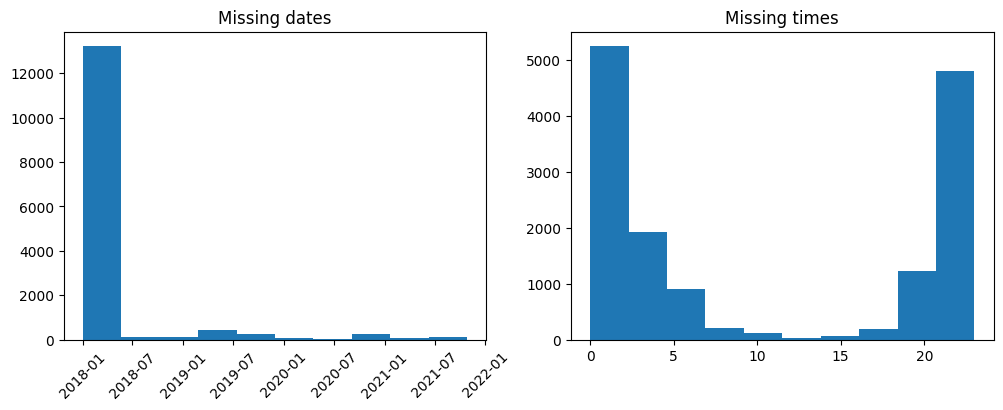

In [ ]:
missing_dates = sorted(set(np.array(pd.date_range(start=df_5.datetime.data[0],end=df_5.datetime.data[-1], freq='5min'))).difference(set(df_5.datetime.data)))
missing_times = np.array(list(map(lambda x: pd.Timestamp(x).to_pydatetime().hour, missing_dates)))

_, ax = plt.subplots(1,2, figsize=(12, 4))
ax[0].hist(missing_dates)
ax[0].tick_params(axis='x', labelrotation=45)
ax[0].set_title("Missing dates")
ax[1].hist(missing_times)
# ax[1].tick_params(axis='x', labelrotation=45)
ax[1].set_title("Missing times")

Most timestamps are missing in 2018 and overnight, but some are absent during the day as well

In [ ]:
# filling index

df_filling_dates_pd = pd.DataFrame(np.full((len(missing_dates), len(ss_ids)), np.nan), columns=ss_ids, index=missing_dates)
df_filling_dates_xr = xr.Dataset.from_dataframe(df_filling_dates_pd)
df_filling_dates_xr = df_filling_dates_xr.rename({'index': 'datetime'})

df_5_full_dates = xr.merge([df_5, df_filling_dates_xr])

df_5_full_dates.to_netcdf(path + 'pv_fulldates.netcdf')
df_5_full_dates = xr.open_dataset(path+'pv_fulldates.netcdf')

## Averaging out from 5 min time resolution to 15 min time resolution

In [ ]:
import warnings

# reshape data per station in rows of 3 for averaging
dict_15 = {}
shape = ((len(df_5_full_dates.datetime.data) + 1)//3, 3)

with warnings.catch_warnings():
  warnings.simplefilter("ignore", category=RuntimeWarning)
  for i, ss in enumerate(ss_ids):
    reshaped_station = np.reshape(np.append(df_5_full_dates[ss].data, df_5_full_dates[ss].data[-1]), shape)
    dict_15[ss] = (["datetime"], np.nanmean(reshaped_station, axis=1))

# new index
datetime_15 = np.array(pd.date_range(start=df_5.datetime.data[0],end=df_5.datetime.data[-1], freq='15min'))

# creating xarray dataset with averaged data and new index
df_15 = xr.Dataset(data_vars=dict_15, coords=dict(datetime=datetime_15))

df_15.to_netcdf('/content/drive/My Drive/pv_15.netcdf')
df_15 = xr.open_dataset(path+'pv_15.netcdf')

Text(0.5, 1.0, 'Data availability, time res=15min')

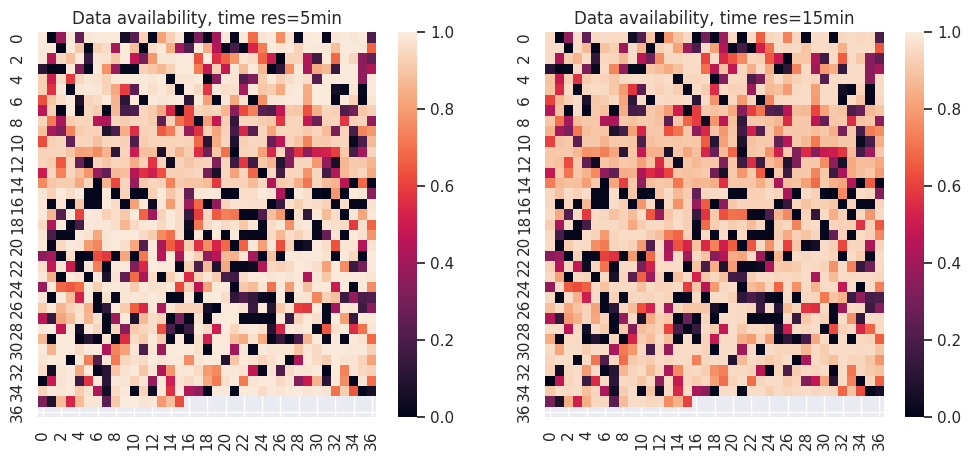

In [ ]:
# missing data in new resolution

heatmap_missing_data_15 = np.full((37*37), np.nan)

for i, ss in enumerate(ss_ids):
  heatmap_missing_data_15[i] = sum(~np.isnan(df_15[ss].data))/len(df_15[ss].data)

np.savetxt(path+'heatmap_missing_data_15.csv', heatmap_missing_data_15, delimiter=',')



heatmap_missing_data_15 = np.genfromtxt(path+'heatmap_missing_data_15.csv', delimiter=',')
heatmap_missing_data_nan = np.genfromtxt(path+'heatmap_missing_data_nan.csv', delimiter=',')

_, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(np.reshape(heatmap_missing_data_nan, (37,37)), vmin=0, vmax=1, ax=ax[0])
ax[0].set_title('Data availability, time res=5min')
sns.heatmap(np.reshape(heatmap_missing_data_15, (37,37)), vmin=0, vmax=1, ax=ax[1])
ax[1].set_title('Data availability, time res=15min')

In [ ]:
print("On average %f of the data is available, the number of stations where less than half of the data is available is %d"
      %(np.nanmean(heatmap_missing_data_15), np.sum(np.where(heatmap_missing_data_15 < 0.5, 1, 0))))

On average 0.679619 of the data is available, the number of stations where less than half of the data is available is 365


## Delete systems that produce overnight

In [ ]:
# from OCF pipelines: https://github.com/openclimatefix/ocf_datapipes/blob/main/ocf_datapipes/load/pv/pv.py
pv_power_watts = df_15.to_dataframe()

NIGHT_YIELD_THRESHOLD = 0.4
night_hours = [22, 23, 0, 1, 2]
pv_power_normalised = pv_power_watts / pv_power_watts.max()
night_mask = pv_power_normalised.index.hour.isin(night_hours)
pv_power_at_night_normalised = pv_power_normalised.loc[night_mask]
pv_above_threshold_at_night = (pv_power_at_night_normalised > NIGHT_YIELD_THRESHOLD).any()
bad_systems = pv_power_normalised.columns[pv_above_threshold_at_night]

df_15 = df_15.drop_vars(bad_systems)

df_15.to_netcdf(path+'pv_15_dropped_night.netcdf')
df_15 = xr.open_dataset(path+'pv_15_dropped_night.netcdf')

In [ ]:
# create new data availability column

data_available_15 = pd.Series(heatmap_missing_data_nan[:len(ss_ids)], index=np.array(ss_ids).astype(int))
data_available_15 = data_available_15.sort_index()
data_available_15 = data_available_15.drop(index=27068)
df_stations_metadata_available['data_available_15'] = data_available_15

df_stations_metadata_available = df_stations_metadata_available.drop(bad_systems.astype(int), axis=0)
df_stations_metadata_available.to_csv(path+'stations_metadata_available.csv')

## Analysis on length of chunks missing

In [ ]:
# from https://stackoverflow.com/questions/41721674/find-consecutive-repeated-nan-in-a-numpy-array
def max_repeatedNaNs_v2(a):
    mask = np.concatenate(([False],np.isnan(a),[False]))
    if ~mask.any():
        return 0
    else:
        idx = np.nonzero(mask[1:] != mask[:-1])[0]
        return (idx[1::2] - idx[::2]).max()

max_len_array = len(df_15.datetime.data)
heatmap_max_gap = np.full(37*37, np.nan)

for i, ss in enumerate(list(df_15.keys())):
  max_missing = max_repeatedNaNs_v2(df_15[ss].data)
  heatmap_max_gap[i] = 1-max_missing/max_len_array

Text(0.5, 1.0, 'Data availability: % of the biggest gap')

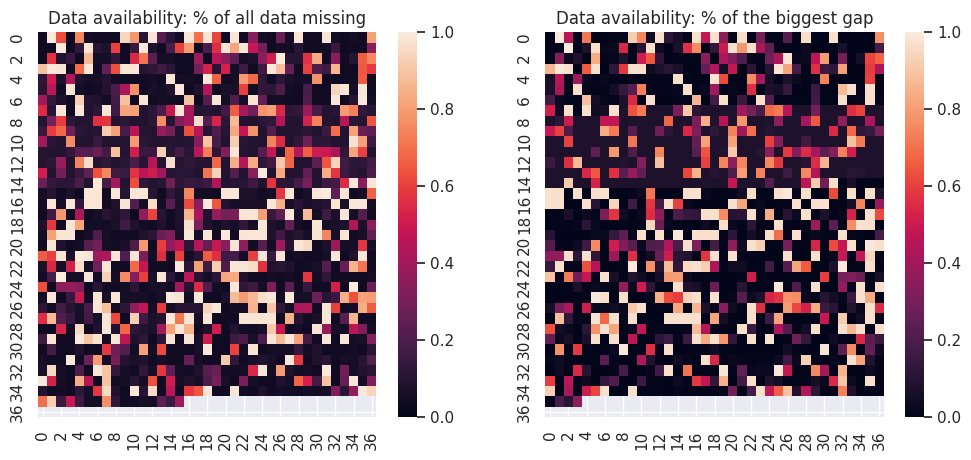

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(np.reshape(1-heatmap_missing_data_15, (37,37)), vmin=0, vmax=1, ax=ax[0])
ax[0].set_title('Data availability: % of all data missing')
sns.heatmap(np.reshape(1-heatmap_max_gap, (37,37)), vmin=0, vmax=1, ax=ax[1])
ax[1].set_title('Data availability: % of the biggest gap')

In [ ]:
print("On average %f of the data is unavailable, the number of stations where less than half of the data is available is %d"
      %(1-np.nanmean(heatmap_missing_data_15), np.sum(np.where(heatmap_missing_data_15 < 0.5, 1, 0))))

print("On average the largest gap covers %f of the data, the number of stations where the largest gap covers more than half is %d"
      %(1-np.nanmean(heatmap_max_gap), np.sum(np.where(heatmap_max_gap < 0.5, 1, 0))))

On average 0.320381 of the data is unavailable, the number of stations where less than half of the data is available is 365
On average the largest gap covers 0.263172 of the data, the number of stations where the largest gap covers more than half is 320


In [ ]:
print("On average %f of the data is unavailable, the number of stations where less than 70 prc of the data is available is %d"
      %(1-np.nanmean(heatmap_missing_data_15), np.sum(np.where(heatmap_missing_data_15 < 0.7, 1, 0))))

print("On average the largest gap covers %f of the data, the number of stations where the largest gap covers more than 70 prc is %d"
      %(1-np.nanmean(heatmap_max_gap), np.sum(np.where(heatmap_max_gap < 0.7, 1, 0))))

On average 0.320381 of the data is unavailable, the number of stations where less than 70 prc of the data is available is 462
On average the largest gap covers 0.263172 of the data, the number of stations where the largest gap covers more than 70 prc is 403


In [ ]:
# column of % of data outside the maximum gap

ss_ids = list(df_15.keys())
data_outside_max_gap = pd.Series(heatmap_max_gap[:len(ss_ids)], index=np.array(ss_ids))
data_outside_max_gap = data_outside_max_gap.sort_index()
data_outside_max_gap = data_outside_max_gap.drop(index='27068')
df_stations_metadata_available['data_outside_max_gap'] = data_outside_max_gap

df_stations_metadata_available.to_csv(path+'stations_metadata_available.csv')

In [ ]:
import plotly.express as px
df = px.data.gapminder().query("year == 2007")
fig = px.scatter_geo(df_stations_metadata_available,
                     lon='longitude_rounded',
                     lat='latitude_rounded',
                     color='data_outside_max_gap')

fig.update_layout(geo_scope='europe', title='Data availability v station location, 15 min res data')
fig.update_geos(fitbounds="locations")
fig.show()

In [ ]:
# drop stations with less than 50% of the data outside maximum gap
df_15_over_50 = df_15.drop_vars(df_stations_metadata_available[df_stations_metadata_available['data_outside_max_gap'] < 0.5].index.values)
df_15_over_50.to_netcdf(path+'df_15_over_50.netcdf')

In [ ]:
print("Overall 980 stations are in the dataset, which means ", int(100*980/1311), "% of the staions were used", sep='')

Overall 980 stations are in the dataset, which means 74% of the staions were used


## Data availability on cleaned 15 min res dataset

In [ ]:
df_15 = xr.open_dataset(path+'pv_15_dropped_night.netcdf')
df_stations_metadata_available = pd.read_csv(path+'stations_metadata_available.csv')

df_stations_metadata_available['ss_id'] = df_stations_metadata_available['ss_id'].astype(str)
df_stations_metadata_available = df_stations_metadata_available.set_index('ss_id', drop=True)

# remove station with no metadata
ss_ids_to_keep = set(df_15.keys())
ss_ids_to_keep.remove('27068')

df_stations_metadata_available = df_stations_metadata_available.loc[list(ss_ids_to_keep)].copy()

In [ ]:
df_15_over_50 = df_15.drop_vars(df_stations_metadata_available[df_stations_metadata_available['data_outside_max_gap'] < 0.5].index.values)

In [ ]:
# pv_power_watts = df_15_over_50.to_dataframe()
pv_power_watts = df_15.to_dataframe()
pv_power_watts['mean'] = np.nanmean(pv_power_watts.values, axis=1)
sum(pv_power_watts['mean'].isna())

<ipython-input-4-61cafbde4eac>:3: RuntimeWarning: Mean of empty slice
  pv_power_watts['mean'] = np.nanmean(pv_power_watts.values, axis=1)


4872

overall 4872 timestamps are missing values across the board

In [ ]:
def repeatedNaNs(a):
    mask = np.concatenate(([False],np.isnan(a),[False]))
    if ~mask.any():
        return 0
    else:
        idx = np.nonzero(mask[1:] != mask[:-1])[0]
        return (idx[1::2] - idx[::2])[:-1], idx

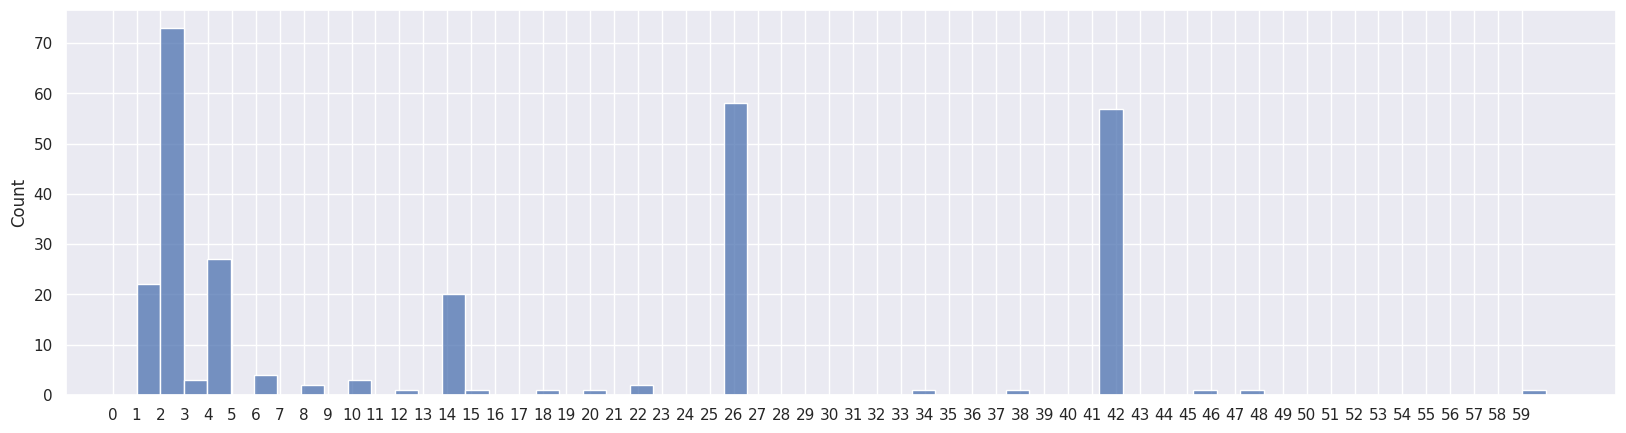

In [ ]:
sns.set(rc={"figure.figsize":(20, 5)}) #width=6, height=5

ax = sns.histplot(repeatedNaNs(pv_power_watts['mean'])[0], bins=60)
# ax.bar_label(ax.containers[1])
ax.set_xticks(np.array(list(range(60))))
ax.tick_params(axis='x', labelrotation=0)
# plt.xticks(np.array(list(range(60))))
# plt.figsize((15,3))

There is a pattern present in missing observations: a lot of them are missing either in chunks of length 42 or length 26. Also a lot of them are missing in pairs, which means in original data a half-hour of observations was missing.

In [ ]:
def get_pairs(a):

  # get pairs of indeces starting and ending a gap

  nans_len, nans_idx = repeatedNaNs(a)

  nan_starts = nans_idx.reshape(len(nans_idx)//2, 2).T[0]
  nan_ends = nans_idx.reshape(len(nans_idx)//2, 2).T[1]

  nans_pairs = np.concatenate([df_15.datetime.data[nan_starts[np.where((nans_len == 26))[0]]],
                                    df_15.datetime.data[nan_ends[np.where((nans_len == 26))[0]]]])
  nans_pairs = nans_pairs.reshape((2, len(nans_pairs)//2))

  return nans_pairs


pairs_mean = get_pairs(pv_power_watts['mean'])

In [ ]:
print("The longest time period missing is %f hours" %((pairs_mean[1] - pairs_mean[0])/np.timedelta64(1, 'h')).max())

The longest time period missing is 6.500000 hours


In [ ]:
print("Minimal time stamp is", min(list(map(lambda x: pd.to_datetime(pd.Timestamp(x).to_pydatetime().time(), format='%H:%M:%S'), pairs_mean[0]))).time(),
      "maximal time stamp is", max(list(map(lambda x: pd.to_datetime(pd.Timestamp(x).to_pydatetime().time(), format='%H:%M:%S'), pairs_mean[1]))).time())

Minimal time stamp is 20:35:00 maximal time stamp is 04:05:00


All of the missing timestamps are missing during the night (between 20:35 and 04:05), so we will impute them as 0.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# pv_power_watts = df_15_over_50.to_dataframe()
pv_power_watts = pd.DataFrame(scaler.fit_transform(pv_power_watts.values), columns=pv_power_watts.columns, index=pv_power_watts.index)

In [ ]:
pv_power_watts['weekday'] = pd.to_datetime(pv_power_watts.index.values).dayofweek
pv_power_watts['month'] = pd.to_datetime(pv_power_watts.index.values).month
pv_power_watts['mean'] = np.nanmean(pv_power_watts.values, axis=1)
pv_power_watts['year'] = pd.to_datetime(pv_power_watts.index.values).year

In [ ]:
pv_power_watts.groupby('year').mean()[pv_power_watts.columns[:-3]].mean(axis=1)

year
2018    0.120587
2019    0.100102
2020    0.100922
2021    0.111241
dtype: float64

(0.0, 0.5)

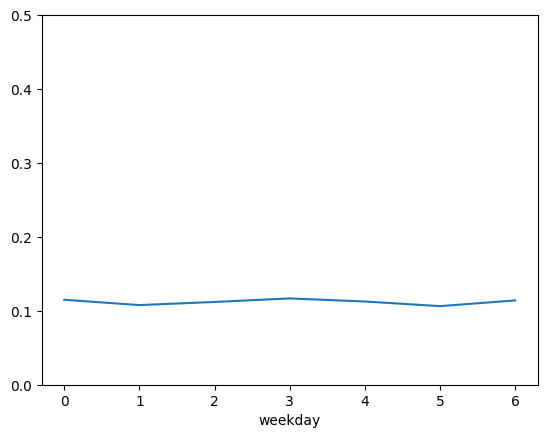

In [ ]:
pv_power_watts.groupby('weekday').mean()[pv_power_watts.columns[:-3]].mean(axis=1).plot()
plt.ylim([0,0.5])

<Axes: xlabel='month'>

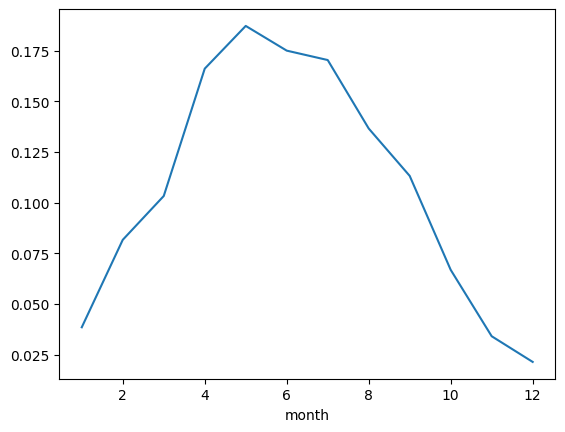

In [ ]:
pv_power_watts.groupby('month').mean()[pv_power_watts.columns[:-3]].mean(axis=1).plot()
# plt.ylim([0,0.5])

(0.0, 0.5)

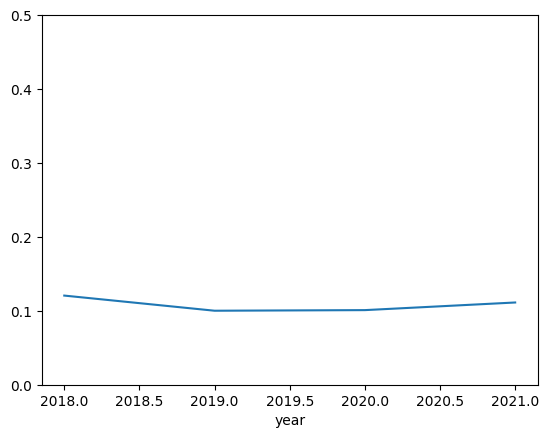

In [ ]:
pv_power_watts.groupby('year').mean()[pv_power_watts.columns[:-3]].mean(axis=1).plot()
plt.ylim([0,0.5])

### Deleting data with less than 2 years available

In [ ]:
# df_15 = xr.open_dataset(path+'pv_15_dropped_night.netcdf')
# df_stations_metadata_available = pd.read_csv(path+'stations_metadata_available.csv')
df_stations_metadata_available = pd.read_csv(path+'metadata.csv')
df_stations_metadata_available['ss_id'] = df_stations_metadata_available['ss_id'].astype(str)
df_stations_metadata_available = df_stations_metadata_available.set_index('ss_id', drop=True)
df_stations_metadata_available.loc['27068', :] = np.full((df_stations_metadata_available.shape[1]), np.nan)

df_15 = xr.open_dataset(path+'pv_15_dropped_night.netcdf')
df_stations_metadata_available.to_csv(path+'stations_metadata_available.csv')

In [ ]:

df_stations_metadata_available = pd.read_csv(path+'stations_metadata_available.csv', index_col=0)

df_stations_metadata_available

,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at
ss_id,,,,,,,
2405,53.53,-1.63,E01007430,180.0,35.0,3.36,2010-11-18
2406,54.88,-1.38,E01008780,315.0,30.0,1.89,2010-12-03
2407,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
2408,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
2409,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
...,...,...,...,...,...,...,...
27064,51.47,-0.59,E01016588,180.0,45.0,2.00,2018-04-18
27065,51.36,-2.93,E01014817,125.0,37.0,4.00,2018-04-18
27066,51.44,-2.85,E01014759,165.0,35.0,4.00,2018-04-18


In [ ]:
pv_power_watts = df_15.to_dataframe()

In [ ]:
pv_power_watts['mean'] = np.nanmean(pv_power_watts.values, axis=1)

In [ ]:
def max_repeatedNaNs_v2(a):
    mask = np.concatenate(([False],np.isnan(a),[False]))
    if ~mask.any():
        return 0
    else:
        idx = np.nonzero(mask[1:] != mask[:-1])[0]
        return (idx[1::2] - idx[::2]).max()

max_len_array = len(df_15.datetime.data)
max_gap = np.full(len(list(df_15.keys())), np.nan)

for i, ss in enumerate(list(df_15.keys())):
  max_gap[i] = max_repeatedNaNs_v2(df_15[ss].data)/max_len_array

In [ ]:
stations_over_50 = np.array(list(df_15.keys()))[np.where(max_gap < 0.5)[0]]

In [ ]:
stations_over_50.shape

(979,)

In [ ]:
df_15_over_50 = df_15[stations_over_50].copy()

In [ ]:
dates_nan = pv_power_watts.index.values[np.where(np.isnan(pv_power_watts['mean']))[0]]
insert_zeros = np.zeros(dates_nan.shape)

In [ ]:
for ss in df_15_over_50.values():
  ss.loc[{'datetime': dates_nan}] = insert_zeros

In [ ]:
df_15_over_50.to_netcdf(path+'df_15_over_50.netcdf')

# Train-test datasets

### Train-test split

In [ ]:
from sklearn.model_selection import train_test_split

# def return_split(df=df_15_over_50, df_metadata=df_stations_metadata_available, test_size=0.3):
def return_split(df, df_metadata, test_size=0.3):

  stations_train, stations_test = train_test_split(list(df.keys()), test_size=test_size)

  if set(stations_train).intersection(set(stations_test)) != set():
    print('ERROR: train and test sets intersect')
    return 0

  df_train = df[stations_train].copy()
  df_test = df[stations_test].copy()

  df_metadata_train = df_metadata.loc[stations_train].copy()
  # df_metadata_train = df_metadata_train.drop(['data_available', 'data_available_15'], axis=1)
  df_metadata_train.to_csv(path+'df_metadata_train.csv', index_label=False)

  df_metadata_test = df_metadata.loc[stations_test].copy()
  # df_metadata_test = df_metadata_test.drop(['data_available', 'data_available_15'], axis=1)
  df_metadata_test.to_csv(path+'df_metadata_test.csv', index_label=False)

  return df_train, df_test, df_metadata_train, df_metadata_test

### Normalization [0, 1]

In [ ]:
def normalize_data(df):
  return (df - df.min())/df.max()

In [ ]:
# df_15_train_normalized.to_netcdf(path + 'df_15_train_normalized.netcdf')
# df_15_test_normalized.to_netcdf(path + 'df_15_test_normalized.netcdf')

### Imputation

In [ ]:
import geopy.distance

def get_weights(coords, df_metadata_train, exponential_weights):

  weights = np.zeros(df_metadata_train.shape[0])

  for i in range(df_metadata_train.shape[0]):

      lat_train = df_metadata_train.iloc[i]['latitude_rounded']
      lon_train = df_metadata_train.iloc[i]['longitude_rounded']

      coords_train = (lat_train, lon_train)

      distance = geopy.distance.distance(coords, coords_train).km

      if distance == 0:
        weights[i] = 0
      else:
        if exponential_weights:
          weights[i] = 1 / np.exp(distance)
        else:
          weights[i] = 1/distance

  return weights

In [ ]:
def impute_missing_data(df, df_metadata, df_train, df_metadata_train, exponential_weights=False):

  array_train = df_train.to_array().data

  for i, ss in enumerate(list(df.keys())):

    if i%50 == 0 : print(i)

    lat = df_metadata.loc[ss]['latitude_rounded']
    lon = df_metadata.loc[ss]['longitude_rounded']

    weights = get_weights((lat, lon), df_metadata_train, exponential_weights)

    ma = np.ma.MaskedArray(array_train, mask=np.isnan(array_train))
    ma = np.ma.average(ma, weights=weights, axis=0)

    ma[np.where(np.isnan(ma))] = np.zeros(len(np.where(np.isnan(ma))))
    if sum(np.isnan(ma)) > 0: print('FILLING WITH NANS')

    ind_to_fill = np.where(np.isnan(df[ss].data))
    df[ss].data[ind_to_fill] = ma[ind_to_fill]

  return df

In [ ]:
def prepare_data(df, df_metadata, exponential_weights=False):

  df_train, df_test, df_metadata_train, df_metadata_test = return_split(df, df_metadata)

  df_train = normalize_data(df_train)
  df_test = normalize_data(df_test)


  df_train_full = impute_missing_data(df=df_train, df_metadata=df_metadata_train,
                                     df_train = df_train, df_metadata_train = df_metadata_train,
                                     exponential_weights = exponential_weights)

  df_test_full = impute_missing_data(df=df_test, df_metadata=df_metadata_test,
                                     df_train = df_train, df_metadata_train = df_metadata_train,
                                     exponential_weights = exponential_weights)

  return df_train, df_test, df_metadata_train, df_metadata_test
return df_train_full, df_test_full


In [ ]:
df_stations_metadata_available.loc[27042]

latitude_rounded          51.91
longitude_rounded         -0.67
llsoacd               E01017591
orientation               225.0
tilt                       30.0
kwp                        3.25
operational_at       2018-04-18
Name: 27042, dtype: object

In [ ]:
df_15_over_50 = xr.open_dataset(path+'df_15_over_50.netcdf')
df_stations_metadata_available = pd.read_csv(path+'stations_metadata_available.csv', index_col=0)
df_stations_metadata_available.index = df_stations_metadata_available.index.astype(str)

exponential_weights=False

df_15_train, df_15_test, df_metadata_train, df_metadata_test = prepare_data(df_15_over_50, df_stations_metadata_available)

df_15_train.to_netcdf('normalised_train.netcdf')
df_15_test.to_netcdf('normalised_test.netcdf')

In [ ]:
df_15_train_full = impute_missing_data(df=df_15_train, df_metadata=df_metadata_train,
                                    df_train = df_15_train, df_metadata_train = df_metadata_train,
                                    exponential_weights = exponential_weights)

df_15_test_full = impute_missing_data(df=df_15_test, df_metadata=df_metadata_test,
                                    df_train = df_15_train, df_metadata_train = df_metadata_train,
                                    exponential_weights = exponential_weights)

df_metadata_train.to_csv(path+'df_metadata_train.csv')
df_metadata_test.to_csv(path+'df_metadata_test.csv')


df_15_test_full.to_netcdf(path+'df_15_test_full.netcdf')
df_15_train_full.to_netcdf(path+'df_15_train_full.netcdf')

In [ ]:
df_test_full.to_netcdf(path+'df_15_test_full.netcdf')
df_15_train_full.to_netcdf(path+'df_15_train_full.netcdf')

In [ ]:
df_distances_train = df_of_neighbours(df_metadata_train, df_metadata_train)

In [ ]:
df_distances_test = df_of_neighbours(df_metadata_test, df_metadata_train)

In [6]:
df_distances_test = pd.read_csv(path+'df_distances_test.csv', index_col=0)
df_distances_train = pd.read_csv(path+'df_distances_train.csv', index_col=0)
df_distances_test.index = df_distances_test.index.astype(str)
df_distances_train.index = df_distances_train.index.astype(str)